# 6. Application of supervised learning

## Imports

In [1]:
import os
import warnings
from datetime import datetime, timedelta
from typing import Optional

import geopandas as gpd
import keras.layers
import keras.losses
import keras.models
import keras.optimizers
import keras.preprocessing
import keras.regularizers
import keras.utils
import lime
import lime.lime_tabular
import matplotlib
import matplotlib.axes
import matplotlib.figure
import matplotlib.pyplot as plt
import meteostat
import numpy as np
import optuna
import pandas as pd
import sklearn.ensemble
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.svm
from tqdm import tqdm

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

2024-06-30 16:27:59.818474: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-30 16:27:59.818791: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-30 16:27:59.822806: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-30 16:27:59.883639: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-30 16:28:00.804018: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

## Classification Parameters

In [2]:
ONLY_KEEP_ACCURATE_DATA = True
KEEP_CHEATING_FEATURES = True
ADD_METEO_STATS = True
NORMALIZE_DATA = True

## Dataset

### Presentation

The dataset deals with Forest Fires in France during the year 2023. It comes from data made available by the government and can be easily downloaded from the website https://bdiff.agriculture.gouv.fr/incendies. I found it while browsing the website https://www.data.gouv.fr/.

This dataset contains information such as the location of the fire (department and city), the date the fire started, the accuracy of the data, the areas affected including forest areas, agricultural areas, and non-natural areas. It details the number of deaths caused, the number of buildings destroyed, and provides information on the type of vegetation affected. Indeed, the value "Type de peuplement" refers to heaths, garrigues, maquis/scrub/deciduous forests/coniferous forests/mixed forests/regeneration or reforestation.

The dataset also includes information on the weather such as temperature, wind direction and wind speed. However, since this information is very rare (more that 90% of these information are lacking), we chose to enrich our dataset by retrieving weather information using the "meteostats" module. You only need the geographical coordinates of a location (its latitude and longitude) and the date to obtain the associated weather information.

You can find additionnal information of the dataset in <a href="./data/incendies/Définitions.pdf">this PDF file</a> that have been downloaded along the CSV file.


### Goals

Another piece of information that quickly caught our interest is the "Nature" of the fire. This can correspond to five different values:

- "Naturelle": in the case of a fire not caused by direct or indirect human activity. This includes fires triggered by lightning, for example.
- "Accidentelle": in the case of a fire caused indirectly by a human event or installation. This includes fires that have started due to a power line rupture or vehicle exhausts.
- "Malveillance": in the case of a fire caused intentionally.
- "Involontaire  (travaux)": in the case of a fire caused by human activities in the context of professional activities but without the intention of starting a fire. This includes forest work, agricultural work, or construction work.
- "Involontaire  (particulier)": in the case of a fire caused by human activities related to private activities (construction work, DIY) or leisure activities, but without the intention of starting a fire.

Thus, the objective will be to attempt to predict the nature of a fire based on the previously described information. If the task proves to be too complex, the classification could at least guide statistical analyses by indicating which information is most useful for prediction.

These predictions and analyses can be very useful for investigations such as the "RCCI" which stands for "Recherche des Causes et des Circonstances de l'Incendie" (Investigation of the Causes and Circumstances of the Fire).
These predictions, along with their confidence levels, could discourage or encourage the initiation of such investigations.

### Load data (downloaded from https://bdiff.agriculture.gouv.fr/incendies)

In [3]:
dfb = pd.read_csv("data/incendies/Incendies.csv", header=2, sep=";")
dfb["Date de première alerte"] = pd.to_datetime(dfb["Date de première alerte"])

ORIGINAL_SIZE = dfb.shape[0]

dfb

,Année,Numéro,Département,Code INSEE,Nom de la commune,Date de première alerte,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),...,Intervention de l'équipe RCCI,Décès ou bâtiments touchés,Nombre de décès,Nombre de bâtiments totalement détruits,Nombre de bâtiments partiellement détruits,Hygrométrie (%),Vitesse moyenne du vent (Km/h),Direction du vent,Température (°C),Précision de la donnée
0,2023,9664,2B,2B046,Cagnano,2023-01-01 10:05:00,100,0.0,100.0,0.0,...,Non,Non,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023,9282,88,88148,Dommartin-lès-Remiremont,2023-01-01 15:29:00,2,2.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023,17212,40,40132,Labatut,2023-01-01 17:54:00,1000,1000.0,NaN,0.0,...,NaN,Non,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,2023,22382,64,64271,Iholdy,2023-01-01 18:11:35,10000,10000.0,NaN,0.0,...,NaN,Non,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,2023,21346,83,83152,Rayol-Canadel-sur-Mer,2023-01-02 20:59:00,35,0.0,35.0,0.0,...,Non,Non,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Données partielles ou non valides
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,2023,21902,83,83069,Hyères,2023-12-27 17:58:00,100,0.0,100.0,0.0,...,Non,Non,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Données partielles ou non valides
2668,2023,13754,07,07275,Saint-Mélany,2023-12-28 11:58:00,100,0.0,100.0,0.0,...,Non,Non,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2669,2023,21903,83,83110,Rougiers,2023-12-28 17:24:00,4,0.0,4.0,0.0,...,Non,Non,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Données partielles ou non valides
2670,2023,21904,83,83036,Cavalaire-sur-Mer,2023-12-29 07:22:00,60,60.0,0.0,0.0,...,Non,Non,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Données partielles ou non valides


### Add longitude and lagitude, dataset downloaded from https://download.geonames.org/export/dump/

In [4]:
column_names_loc = [
    "country",
    "Code INSEE",
    "City",
    "Région",
    "Unknown",
    "Departement",
    "Département Code",
    "Unknown2",
    "Unknown3",
    "lattitude",
    "longitude",
    "Unknown4",
]
df_lat_long = pd.read_csv("data/location/FR.txt", header=2, sep="\t", names=column_names_loc)
df_lat_long

,country,Code INSEE,City,Région,Unknown,Departement,Département Code,Unknown2,Unknown3,lattitude,longitude,Unknown4
0,FR,75002,Paris 02,Île-de-France,11.0,Paris,75,Paris,751,48.8655,2.3426,5
1,FR,75002,Paris,Île-de-France,11.0,Paris,75,Paris,751,48.8534,2.3488,5
2,FR,75003,Paris,Île-de-France,11.0,Paris,75,Paris,751,48.8534,2.3488,5
3,FR,75003,Paris 03,Île-de-France,11.0,Paris,75,Paris,751,48.8637,2.3615,5
4,FR,75004,Paris 04,Île-de-France,11.0,Paris,75,Paris,751,48.8601,2.3507,5
...,...,...,...,...,...,...,...,...,...,...,...,...
51669,FR,20601 CEDEX,Bastia,Corse,94.0,Haute-Corse,2B,Bastia,2B2,42.7022,9.4512,5
51670,FR,20604 CEDEX,Bastia,Corse,94.0,Haute-Corse,2B,Bastia,2B2,42.7022,9.4512,5
51671,FR,20611 CEDEX,Bastia,Corse,94.0,Haute-Corse,2B,Bastia,2B2,42.7022,9.4512,5
51672,FR,20620,Biguglia,Corse,94.0,Haute-Corse,2B,Bastia,2B2,42.6269,9.4202,5


In [5]:
# add lacking city by the location of a city near (of the same departement)
lacking_cities = dfb[~dfb["Nom de la commune"].isin(df_lat_long["City"])]
for _, row in tqdm(lacking_cities.iterrows(), total=lacking_cities.shape[0], desc="Add lat and long of lacking cities"):
    df2 = df_lat_long[df_lat_long["Département Code"] == row["Département"]].copy()
    if df2.shape[0] > 0:
        df2["City"] = row["Nom de la commune"]
    else:
        mapper = {"974": (-21.114533, 55.532062), "976": (-12.824511, 45.165455)}
        lat, lon = mapper[row["Département"]]
        df2 = pd.DataFrame(
            [
                {
                    "lattitude": -21.114533,
                    "longitude": 55.532062,
                    "City": row["Nom de la commune"],
                }
            ],
            columns=column_names_loc,
        )
    df_lat_long = pd.concat([df_lat_long, df2.iloc[:1]])

# remove duplicate
print("remove duplicate df_lat_long")
df_lat_long = df_lat_long.groupby(by="City").first().reset_index()

Add lat and long of lacking cities: 100%|██████████| 75/75 [00:00<00:00, 171.68it/s]

remove duplicate df_lat_long


In [6]:
# merge so that the original dataset have lattitude and longitude as columns
dfb2 = pd.merge(left=dfb, right=df_lat_long[["lattitude", "longitude", "City"]], left_on="Nom de la commune", right_on="City", how="inner", validate="many_to_one")
dfb2.drop(columns=["City"], inplace=True)

dfb2

,Année,Numéro,Département,Code INSEE,Nom de la commune,Date de première alerte,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),...,Nombre de décès,Nombre de bâtiments totalement détruits,Nombre de bâtiments partiellement détruits,Hygrométrie (%),Vitesse moyenne du vent (Km/h),Direction du vent,Température (°C),Précision de la donnée,lattitude,longitude
0,2023,9664,2B,2B046,Cagnano,2023-01-01 10:05:00,100,0.0,100.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.8783,9.4537
1,2023,9282,88,88148,Dommartin-lès-Remiremont,2023-01-01 15:29:00,2,2.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.9990,6.6405
2,2023,17212,40,40132,Labatut,2023-01-01 17:54:00,1000,1000.0,NaN,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,43.5507,-0.9845
3,2023,22382,64,64271,Iholdy,2023-01-01 18:11:35,10000,10000.0,NaN,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,43.2826,-1.1808
4,2023,21346,83,83152,Rayol-Canadel-sur-Mer,2023-01-02 20:59:00,35,0.0,35.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Données partielles ou non valides,43.1667,6.4667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,2023,21902,83,83069,Hyères,2023-12-27 17:58:00,100,0.0,100.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Données partielles ou non valides,43.1204,6.1286
2668,2023,13754,07,07275,Saint-Mélany,2023-12-28 11:58:00,100,0.0,100.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,44.5299,4.1183
2669,2023,21903,83,83110,Rougiers,2023-12-28 17:24:00,4,0.0,4.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Données partielles ou non valides,43.3923,5.8511
2670,2023,21904,83,83036,Cavalaire-sur-Mer,2023-12-29 07:22:00,60,60.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Données partielles ou non valides,43.1726,6.5296


### Get stats of the meteo with the module "meteostats"

In [7]:
columns = {
    'temp': 'temperature',
    'dwpt': 'dew_point',
    'rhum': 'relative_humidity',
    'prcp': 'precipitation',
    'snow': 'snowfall',
    'wdir': 'wind_direction',
    'wspd': 'wind_speed',
    'wpgt': 'wind_gust',
    'pres': 'pressure',
    'tsun': 'sunshine_duration',
    'coco': 'weather_code'
}

def get_meteo_stat(lattitude: float, longitude: float, date: datetime, name : Optional[str] = None) -> pd.DataFrame:

    if name:
        print(name)

    point = meteostat.Point(lat=lattitude, lon=longitude)

    data = meteostat.Hourly(point, date - timedelta(hours=24), date)
    data = data.fetch()
    if data.shape[0] != 0:
        # return the closest hour
        return data.iloc[-1:]
    
    # if no data found, add an empty line
    data = pd.DataFrame([[np.nan] * len(columns.keys())], columns=columns)
    data.index.name = "time"
    return data
    
# the main loop
df_meteostats = [
    get_meteo_stat(
        lattitude=row["lattitude"],
        longitude=row["longitude"],
        date=row["Date de première alerte"],
    )
    for _, row in tqdm(dfb2.iterrows(), total=dfb2.shape[0])
]
df_meteostats = pd.concat(df_meteostats).reset_index()

# rename columns
df_meteostats.rename(columns=columns, inplace=True)
df_meteostats.rename(columns={"time" : "time_meteostats"}, inplace=True)

df_meteostats

100%|██████████| 2672/2672 [02:01<00:00, 22.08it/s]


,time_meteostats,temperature,dew_point,relative_humidity,precipitation,snowfall,wind_direction,wind_speed,wind_gust,pressure,sunshine_duration,weather_code
0,2023-01-01 10:00:00,14.1,12.3,89.0,0.0,NaN,190.0,27.7,18.5,1031.1,NaN,2.0
1,2023-01-01 15:00:00,15.0,6.8,58.0,0.0,NaN,172.0,11.1,29.6,1019.6,NaN,3.0
2,2023-01-01 17:00:00,21.0,1.8,28.0,0.0,NaN,200.0,16.6,NaN,1015.2,NaN,3.0
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-02 20:00:00,13.7,12.8,94.0,0.0,NaN,90.0,18.4,14.8,1027.0,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2667,2023-12-27 17:00:00,12.7,9.7,82.0,0.0,NaN,90.0,14.8,16.7,1025.9,NaN,2.0
2668,2023-12-28 11:00:00,8.3,7.2,93.0,0.0,NaN,170.0,3.6,NaN,1027.6,NaN,3.0
2669,2023-12-28 17:00:00,10.4,9.0,91.0,0.0,NaN,100.0,18.4,NaN,1025.7,NaN,3.0
2670,2023-12-29 07:00:00,9.0,6.6,85.0,0.0,NaN,280.0,9.4,16.7,1023.1,NaN,3.0


In [8]:
# add meteo stats in the main dataframe
df_all = pd.concat([dfb2, df_meteostats], axis=1)
df_all

,Année,Numéro,Département,Code INSEE,Nom de la commune,Date de première alerte,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),...,dew_point,relative_humidity,precipitation,snowfall,wind_direction,wind_speed,wind_gust,pressure,sunshine_duration,weather_code
0,2023,9664,2B,2B046,Cagnano,2023-01-01 10:05:00,100,0.0,100.0,0.0,...,12.3,89.0,0.0,NaN,190.0,27.7,18.5,1031.1,NaN,2.0
1,2023,9282,88,88148,Dommartin-lès-Remiremont,2023-01-01 15:29:00,2,2.0,NaN,0.0,...,6.8,58.0,0.0,NaN,172.0,11.1,29.6,1019.6,NaN,3.0
2,2023,17212,40,40132,Labatut,2023-01-01 17:54:00,1000,1000.0,NaN,0.0,...,1.8,28.0,0.0,NaN,200.0,16.6,NaN,1015.2,NaN,3.0
3,2023,22382,64,64271,Iholdy,2023-01-01 18:11:35,10000,10000.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023,21346,83,83152,Rayol-Canadel-sur-Mer,2023-01-02 20:59:00,35,0.0,35.0,0.0,...,12.8,94.0,0.0,NaN,90.0,18.4,14.8,1027.0,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,2023,21902,83,83069,Hyères,2023-12-27 17:58:00,100,0.0,100.0,0.0,...,9.7,82.0,0.0,NaN,90.0,14.8,16.7,1025.9,NaN,2.0
2668,2023,13754,07,07275,Saint-Mélany,2023-12-28 11:58:00,100,0.0,100.0,0.0,...,7.2,93.0,0.0,NaN,170.0,3.6,NaN,1027.6,NaN,3.0
2669,2023,21903,83,83110,Rougiers,2023-12-28 17:24:00,4,0.0,4.0,0.0,...,9.0,91.0,0.0,NaN,100.0,18.4,NaN,1025.7,NaN,3.0
2670,2023,21904,83,83036,Cavalaire-sur-Mer,2023-12-29 07:22:00,60,60.0,0.0,0.0,...,6.6,85.0,0.0,NaN,280.0,9.4,16.7,1023.1,NaN,3.0


## Preprocess

In [9]:
df = df_all.copy()

### Manage Nan values

In [10]:
# display the percentage of missing values for columns that have at least one missing value
def compute_percentage_na(df : pd.DataFrame) -> pd.Series:
    return df.isna().astype(int).sum(axis=0) / df.shape[0]
percentage_na = compute_percentage_na(df)
percentage_na[percentage_na > 0]

Surface forêt (m2)                                 0.000374
Surface maquis garrigues (m2)                      0.312500
Autres surfaces naturelles hors forêt (m2)         0.025075
Surfaces agricoles (m2)                            0.022455
Autres surfaces (m2)                               0.023952
Surface autres terres boisées (m2)                 1.000000
Surfaces non boisées naturelles (m2)               1.000000
Surfaces non boisées artificialisées (m2)          1.000000
Surfaces non boisées (m2)                          1.000000
Surface de feu à l'arrivée des secours > 0,1 ha    0.745135
Type de peuplement                                 0.684880
Connaissance de la cause                           0.013473
Nature                                             0.434880
Intervention de l'équipe RCCI                      0.329341
Décès ou bâtiments touchés                         0.013847
Nombre de décès                                    0.742889
Nombre de bâtiments totalement détruits 

In [11]:
# Décès ou bâtiments touchés : NaN => 'Non' (we consider that no information given means no destroyed building)
df.loc[df["Décès ou bâtiments touchés"].isna(), "Décès ou bâtiments touchés"] = (
    "Non"
)

# Type de peuplement : NaN => 0 (category 0 : Unknwown)
df.loc[df["Type de peuplement"].isna(), "Type de peuplement"] = 0
steps = ["Unknown", "Landes,garrigues,maquis", "taillis", "futaies feuillues",  "futaies résineuses", "futaies mélangées", "régénération et reboisement"]
for i, name in enumerate(steps):
    df.loc[df["Type de peuplement"] == i, "Type de peuplement"] = name

# Intervention de l'équipe RCCI : NaN => 'Non'
df.loc[df["Intervention de l'équipe RCCI"].isna(), "Intervention de l'équipe RCCI"] = (
    "Non"
)

# Surface parcourue (m2), Surface forêt (m2)... : NaN => 0
nan_to_zero = [
    "Surface parcourue (m2)",
    "Surface forêt (m2)",
    "Surface maquis garrigues (m2)",
    "Autres surfaces (m2)",
    "Autres surfaces naturelles hors forêt (m2)",
    "Surfaces agricoles (m2)",
    "Nombre de décès",
    "Nombre de bâtiments totalement détruits",
    "Nombre de bâtiments partiellement détruits",
    "weather_code", # weather_code=0 means clear sky 
    "snowfall",
]
for column in nan_to_zero:
    df.loc[df[column].isna(), column] = 0

# set values to its mean
nan_to_mean = [
    "temperature",
    "dew_point",
    "relative_humidity",
    "pressure",
    "precipitation",
    "wind_direction", # does not make very sense but mehhh
    "wind_speed"
]
for column in nan_to_mean:
    df.loc[df[column].isna(), column] = df[column].mean()

# drop columns that have too much NaN and that can't be replaced by a default value
df.drop(
    columns=[
        "Surface autres terres boisées (m2)",
        "Surfaces non boisées naturelles (m2)",
        "Surfaces non boisées artificialisées (m2)",
        "Surfaces non boisées (m2)",
        "Surface de feu à l'arrivée des secours > 0,1 ha",
        "Hygrométrie (%)",
        "Vitesse moyenne du vent (Km/h)",
        "Direction du vent",
        "Température (°C)",
        "sunshine_duration",
        "wind_gust"
    ],
    inplace=True,
    errors="ignore"
)

### Add columns from existing columns

In [12]:
# Add column : 'month'
df['month'] = df['Date de première alerte'].dt.month
# Add column : 'hour'
df['hour'] = df['Date de première alerte'].dt.hour

# Add all significations of wheather code
weather_codes = {
    "No significant weather or clear skies": (0, 19),
    "Precipitation but not reaching the ground": (20, 29),
    "Dust or sand": (30, 39),
    "Fog or mist": (40, 49),
    "Drizzle": (50, 59),
    "Rain": (60, 69),
    "Snow or ice pellets": (70, 79),
    "Showers, thunderstorms, and other significant weather events": (80, 99)
}
df["weather_code_category"] = None
for name, bounds in weather_codes.items():
    low, high = bounds
    df.loc[(low <= df["weather_code"]) & (df["weather_code"] <= high), "weather_code_category"] = name

### Filter

In [13]:
# Only keep accurate data
if ONLY_KEEP_ACCURATE_DATA:
    df = df[df["Précision de la donnée"] != "Données partielles ou non valides"]

df.loc[df["Précision de la donnée"].isna(), "Précision de la donnée"] = "Bonne"

# Only keep those who the nature of the fire ignition is known
df = df[df["Connaissance de la cause"] != "Inconnue"]
df = df[~df["Nature"].isna()]

print("Original size :    ", ORIGINAL_SIZE)
print("Size after filter :", df.shape[0])

Original size :     2672
Size after filter : 1257


## Statistical analyses

I do not advice you to look after each graph by yourselve.
Read the conclusion at first and if you are interested in some point, check by yourself the stats.
Graph are well organized so it should not be too had.

### Classes balance

<Axes: title={'center': 'Number of fire for each nature'}, xlabel='Nature'>

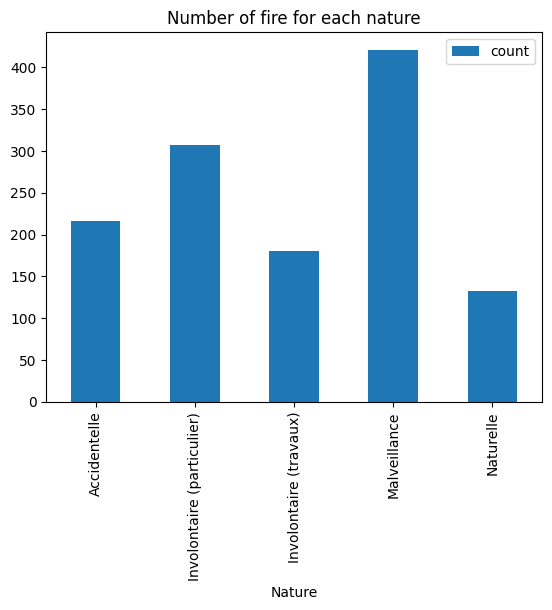

In [14]:
df.groupby(by="Nature").count().rename(columns={"Numéro": "count"})[["count"]].plot(kind="bar", title="Number of fire for each nature")

### Location

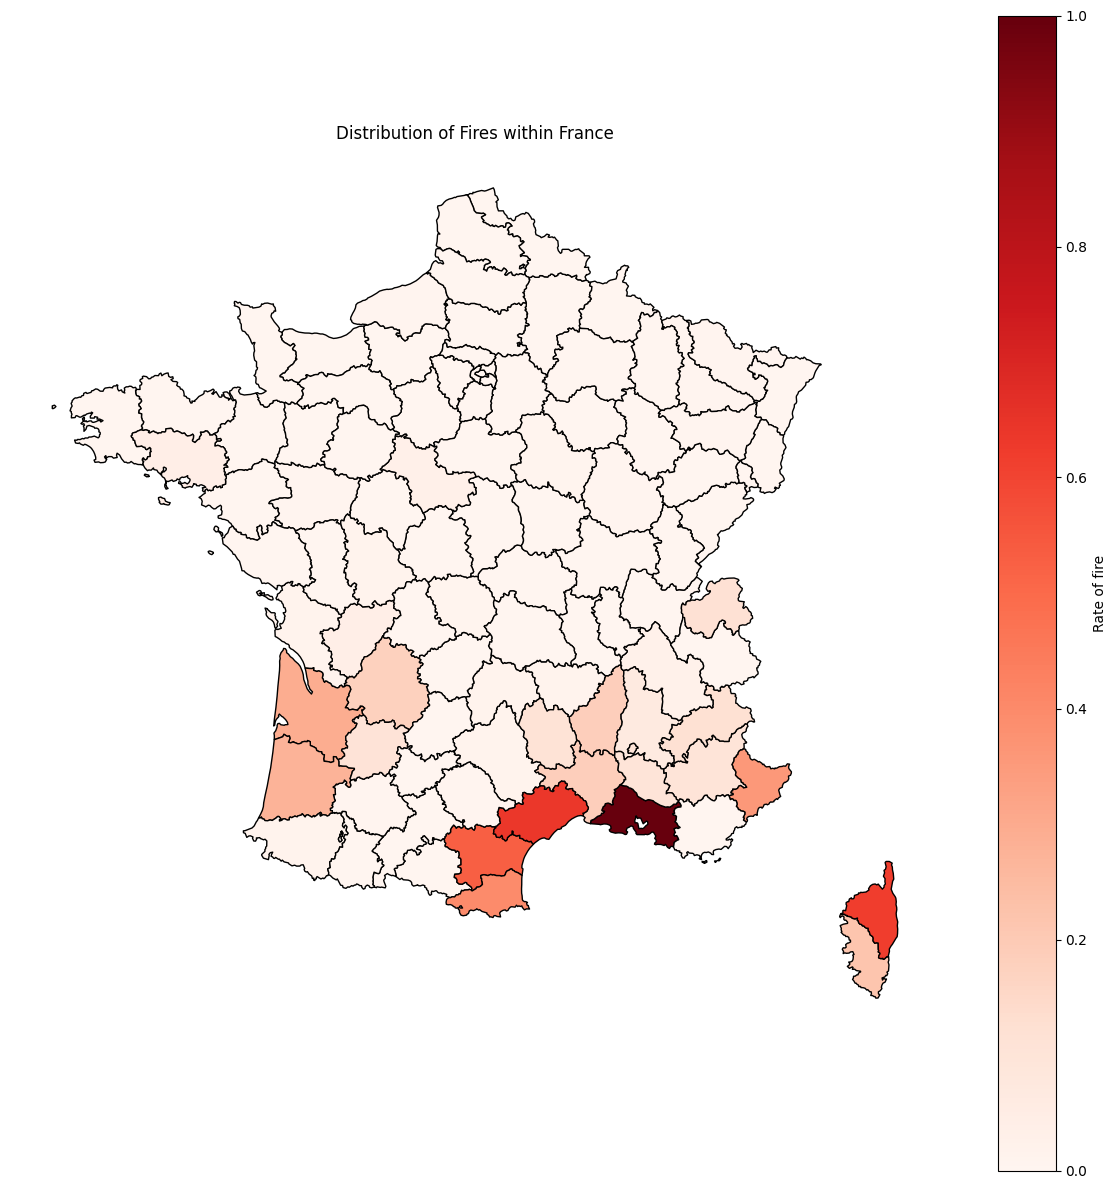

In [15]:
def plot_france(df : pd.DataFrame, fig : matplotlib.figure.Figure, ax : plt.Axes, title : str, last : bool = True) -> None:
    # Load the shapefile of France departments including DOM-TOM if available
    url = 'https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements-version-simplifiee.geojson'
    france = gpd.read_file(url)

    department_colors = {
        code : 0
        for code in france['code']
    }

    df2 = df.groupby(by="Département").count().rename(columns={"Numéro": "count"})[["count"]]
    df2 = (df2-df2.min())/(df2.max()-df2.min())
    for code, row in df2.iterrows():
        department_colors[code] = row["count"]

    # Create a color map that ranges from light red to dark red
    cmap = plt.cm.Reds

    for code, color in department_colors.items():
        department_colors[code] = cmap(color)

    # Plot the departments with the specified colors
    france.plot(ax=ax, color=list(department_colors.values()), edgecolor='black')
    ax.set_title(title)

    # Remove axes for better visual
    ax.set_axis_off()

    # Add a color bar to show the gradient scale
    if last:
        sm = plt.cm.ScalarMappable(cmap=cmap)
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label('Rate of fire')

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
plot_france(df, fig, ax, "Distribution of Fires within France")

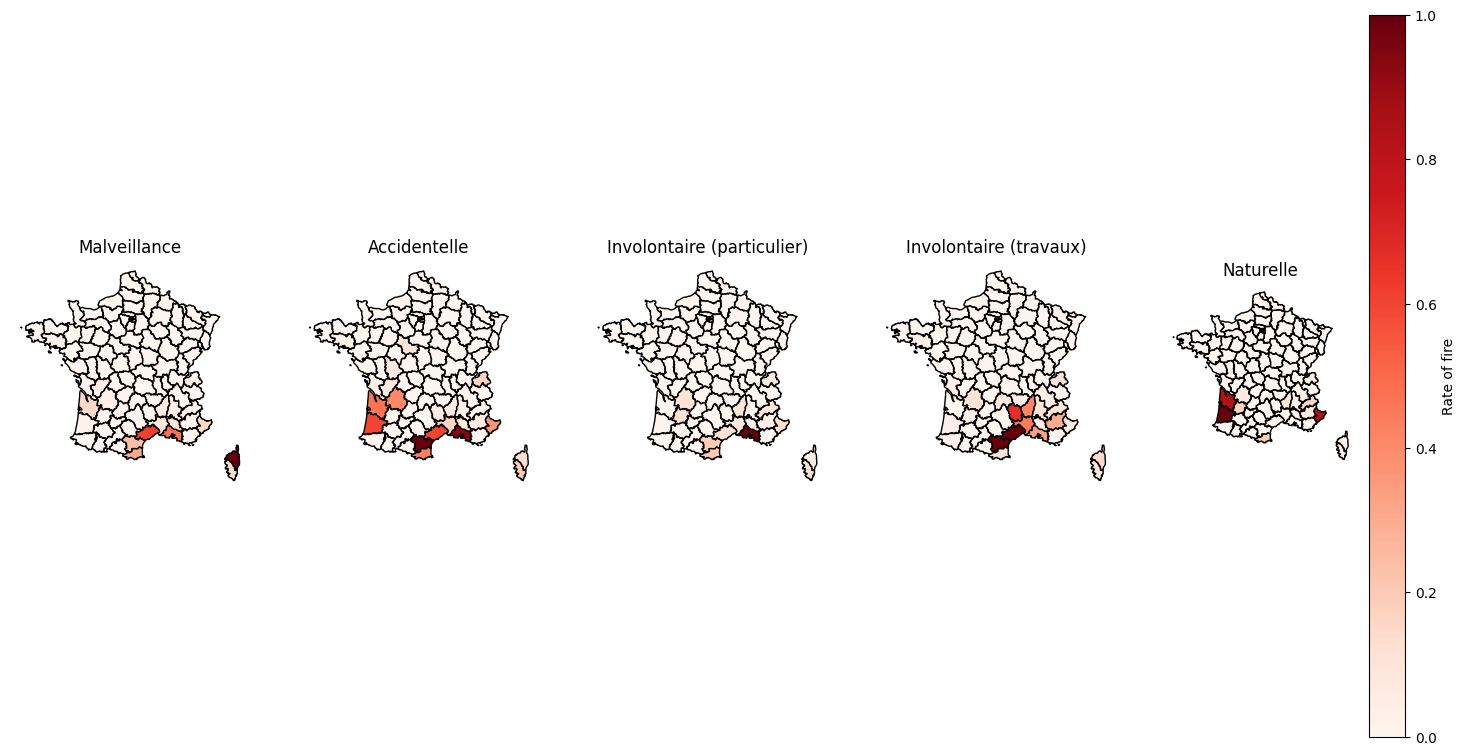

In [16]:
fig, axes = plt.subplots(1, df["Nature"].unique().shape[0], figsize=(18, 15))
for index, nature in enumerate(df["Nature"].unique()):
    plot_france(df[df["Nature"] == nature], fig, axes[index], nature, last=(index+1==df["Nature"].unique().shape[0]))

### Date

<Axes: xlabel='Année'>

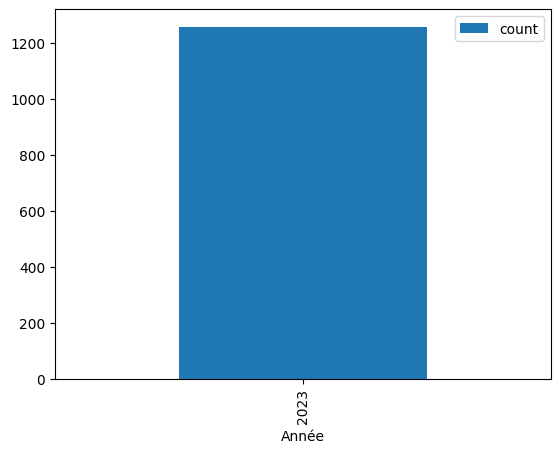

In [17]:
# just a reminder
df.groupby(by="Année").count().rename(columns={"Numéro": "count"})[["count"]].plot(kind="bar")

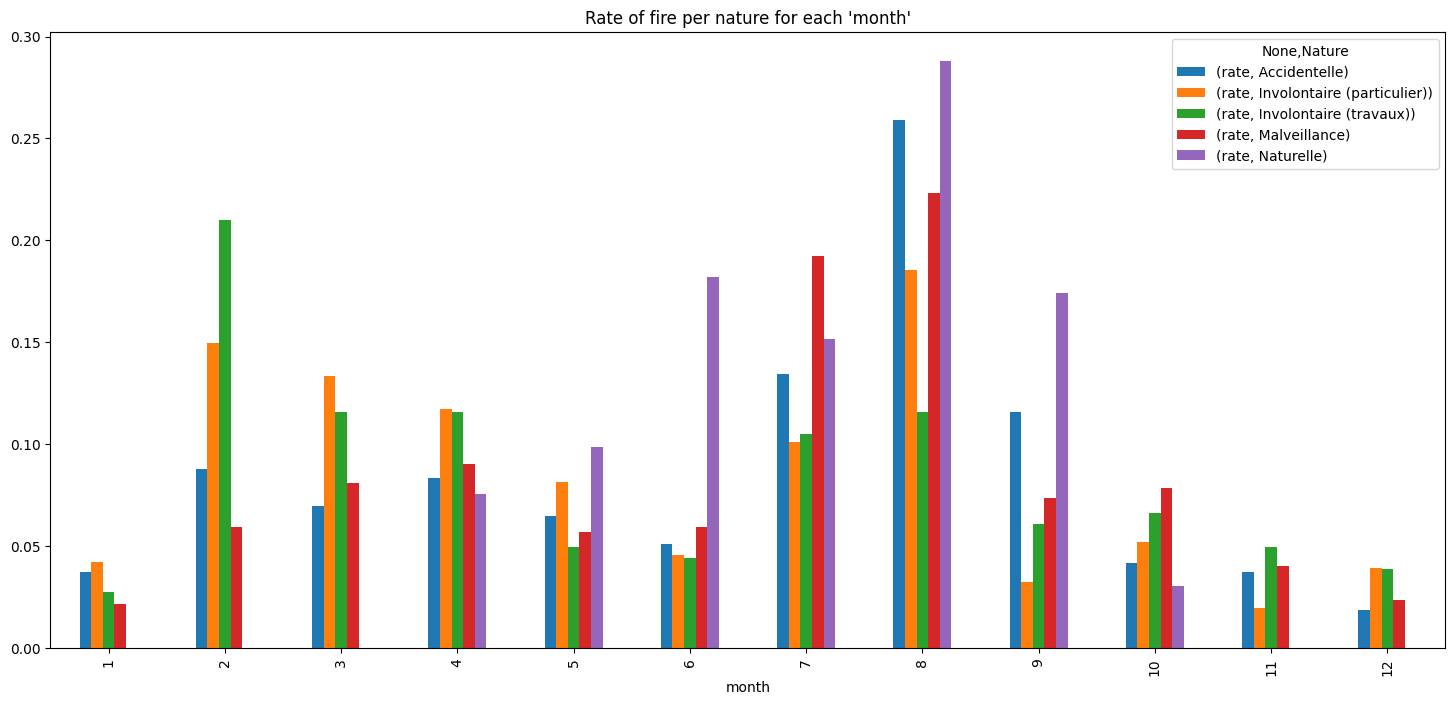

In [18]:
def display_column_per_nature(df : pd.DataFrame, column_name : str, ax : matplotlib.axes.Axes = None, title : str = None, kind : str = "bar", logy = False ) -> None:
    df2 = (
        df.groupby(by=[column_name, "Nature"])
        .count()
        .rename(columns={"Numéro": "count"})[["count"]]
    )
    df2 = (
        df2
        / df.groupby(by=["Nature"]).count().rename(columns={"Numéro": "count"})[["count"]]
    )
    df2.rename(columns={"count": "rate"}, inplace=True)
    title = title or f"Rate of fire per nature for each '{column_name}'"
    # for each nature, the num of the values equal to one
    df2.unstack("Nature").plot(
        kind=kind, title=title, figsize=(18, 8) if ax is None else None, ax=ax, logy=logy
    )
display_column_per_nature(df, "month")

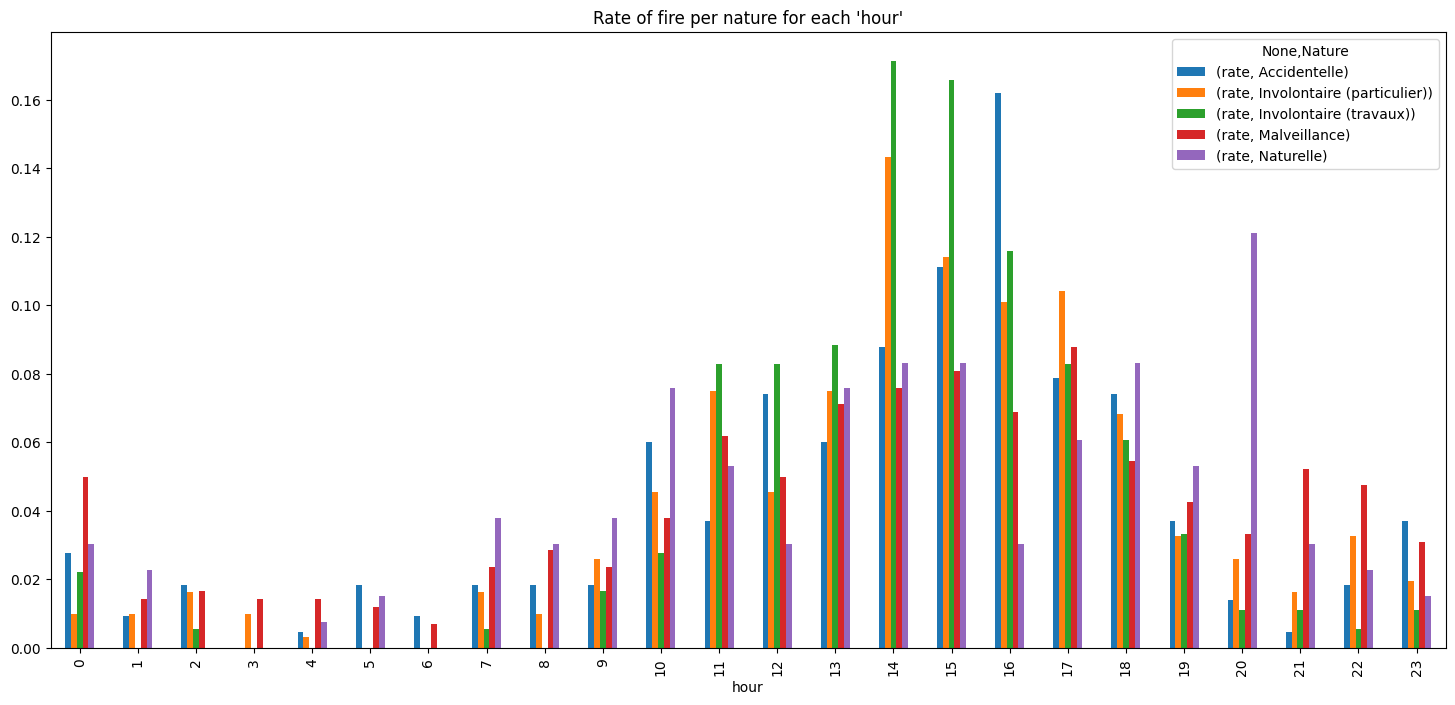

In [19]:
display_column_per_nature(df, "hour")

### Others

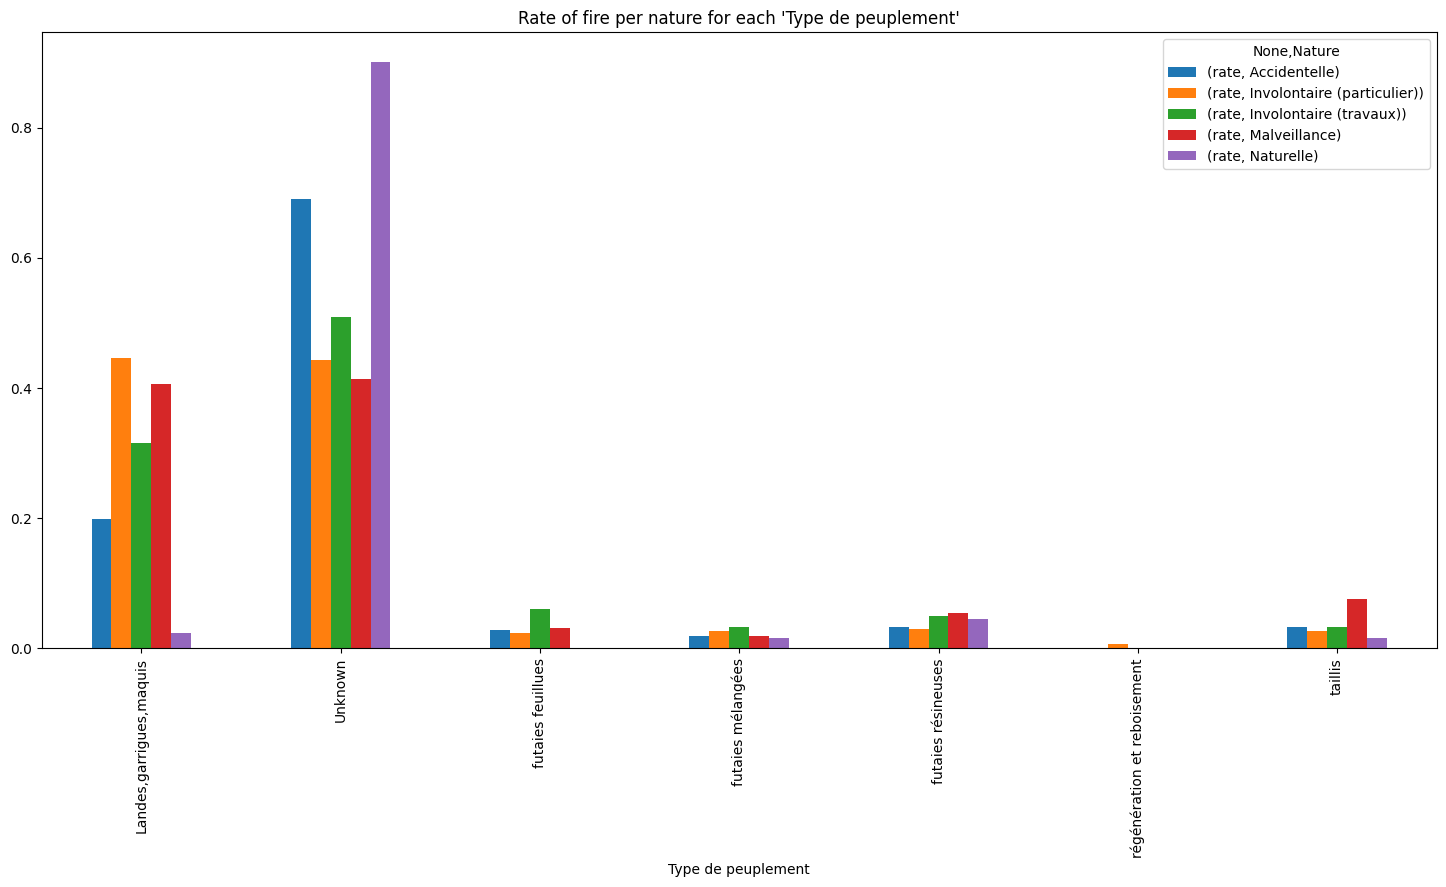

In [20]:
display_column_per_nature(df, "Type de peuplement")

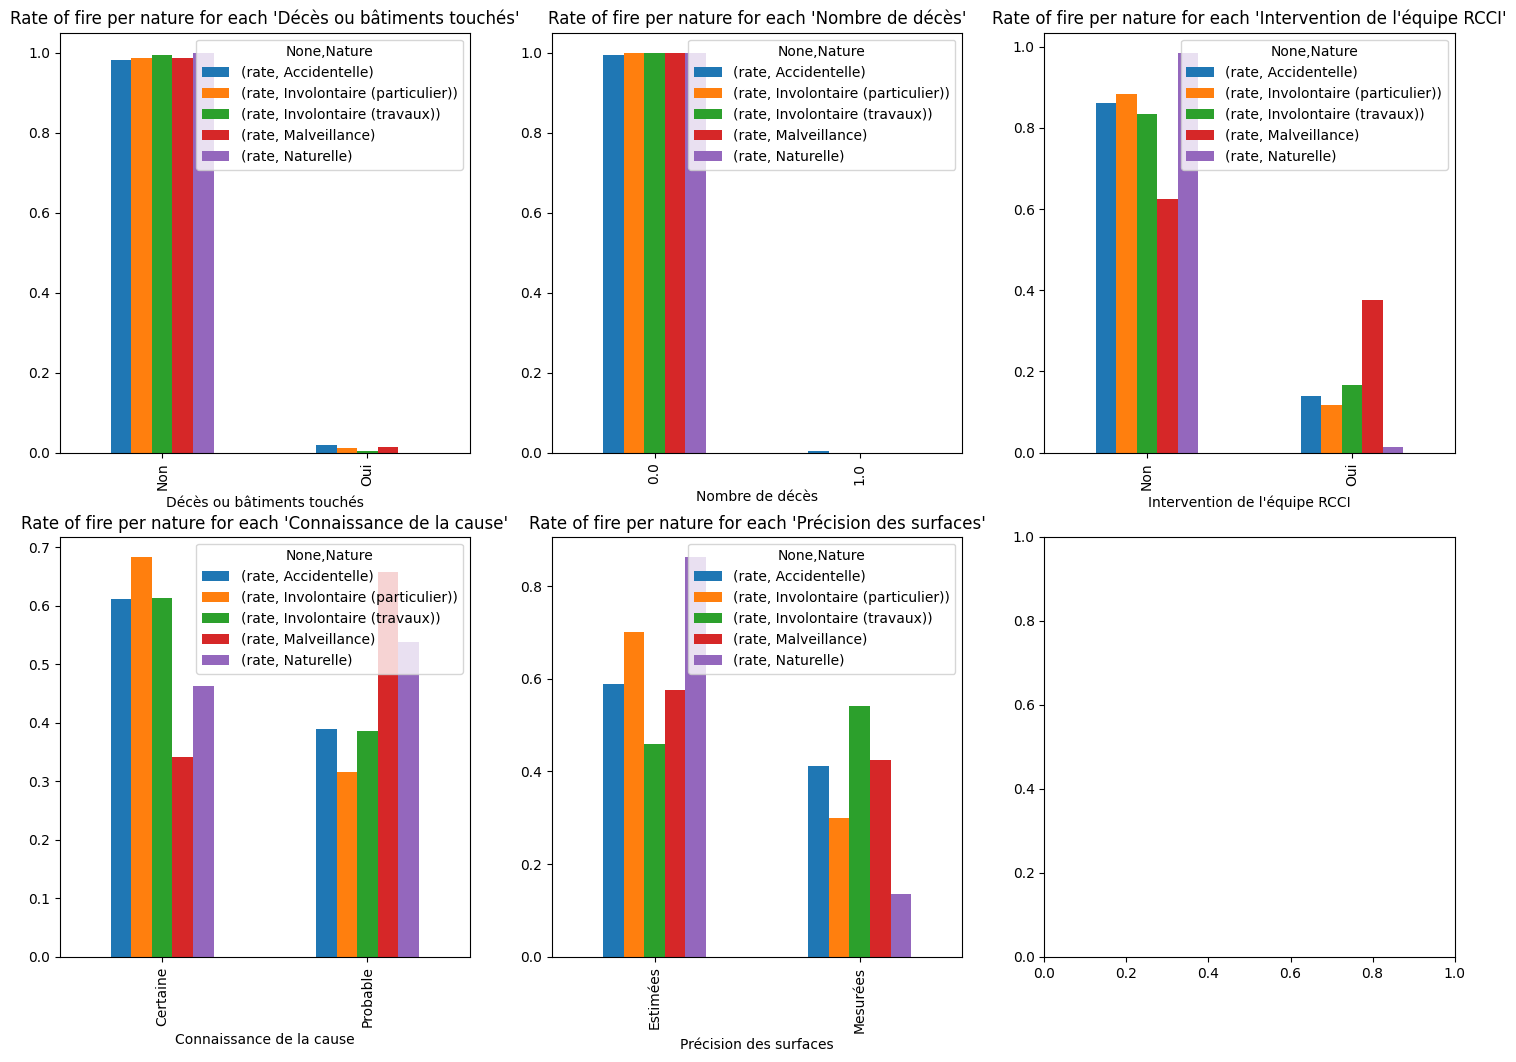

In [21]:

l = ["Décès ou bâtiments touchés", "Nombre de décès", "Intervention de l'équipe RCCI", "Connaissance de la cause", "Précision des surfaces"]
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for index, column_name in enumerate(l):
    display_column_per_nature(df, column_name, ax=axes[index // 3][index % 3])

### Meteo stats

<Axes: xlabel='hour', ylabel='temperature'>

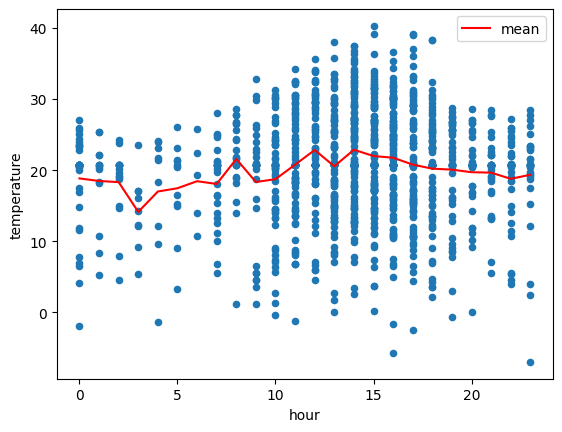

In [22]:
fig, ax = plt.subplots(1, 1)
df.plot.scatter(x="hour", y="temperature", ax=ax)
df.groupby(by="hour").agg({"temperature": "mean"}).rename(columns={"temperature": "mean"}).reset_index().plot.line(x="hour", y="mean", color="red", ax=ax)

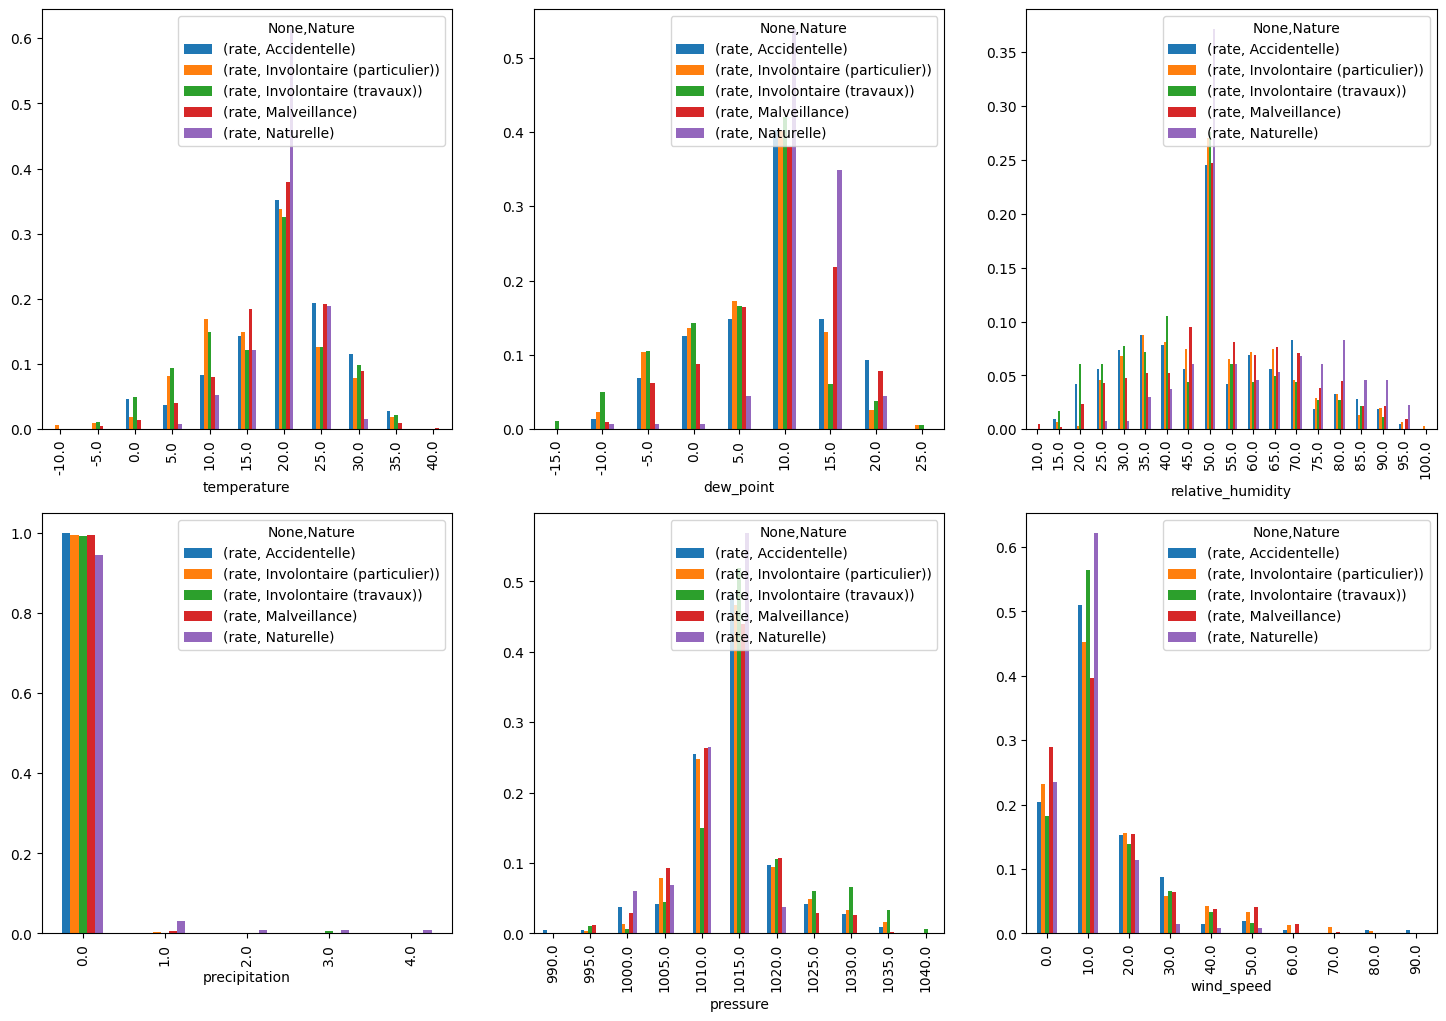

In [23]:
def display_column_per_nature_continuous_value(df : pd.DataFrame, column_name : str, group : int, ax: matplotlib.axes.Axes = None, kind: str = "bar", logy=False) -> None:
    df2 = df.copy()
    df2[column_name] = df2[column_name] // group * group
    display_column_per_nature(df2, column_name, ax=ax, kind=kind, logy=logy)
    if ax is not None:
        ax.set_title(None)

l = [("temperature", 5), ("dew_point", 5), ("relative_humidity", 5), ("precipitation", 1), ("pressure", 5), ("wind_speed", 10)]
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for index, value in enumerate(l):
    column_name, group = value
    display_column_per_nature_continuous_value(df, column_name, group, ax=axes[index // 3][index % 3])

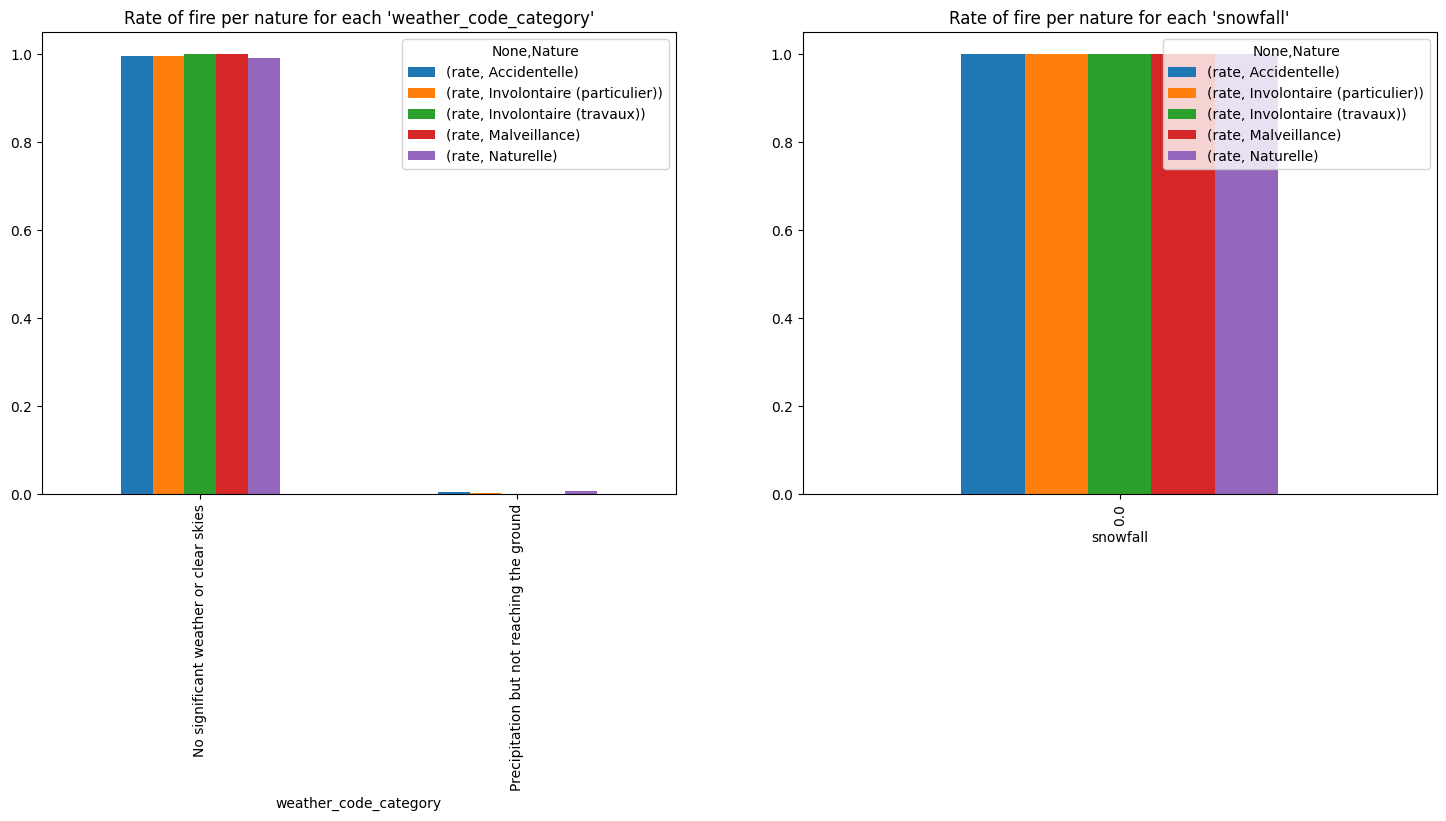

In [24]:
l = ["weather_code_category", "snowfall"]
_, axes = plt.subplots(1, len(l), figsize=(18, 6))

for index, column_name in enumerate(l):
    display_column_per_nature(df, column_name, ax=axes[index])

### Surfaces

In [25]:
surfaces = [column_name for column_name in df.columns if column_name.startswith("Surface") or column_name.startswith("Autres surface")]
metrics = {
    "min": lambda x : x.min(),
    "max": lambda x : x.max(),
    "mean": lambda x : x.mean(),
    "std": lambda x : x.std(),
    "first_quartile": lambda x : x.quantile(0.25),
    "median": lambda x : x.median(),
    "third_quartile": lambda x : x.quantile(0.75),
}
categories = df["Nature"].unique()
data = {
    metric_name : []
    for metric_name in metrics.keys()
}

for surface in surfaces:
    for metric_name, func in metrics.items():
        for category in categories:
            data[metric_name].append(func(df[df["Nature"] == category][surface]))

index = pd.MultiIndex.from_arrays([
    [surface for surface in surfaces for _ in categories],
    [category for _ in surfaces for category in categories],
], names=("Surface type", "Nature"))
df_stats_surfaces = pd.DataFrame(data, index=index)
df_stats_surfaces

min  \
Surface type                               Nature                            
Surface parcourue (m2)                     Malveillance                1.0   
                                           Accidentelle                2.0   
                                           Involontaire (particulier)  1.0   
                                           Involontaire (travaux)      1.0   
                                           Naturelle                   1.0   
Surface forêt (m2)                         Malveillance                0.0   
                                           Accidentelle                0.0   
                                           Involontaire (particulier)  0.0   
                                           Involontaire (travaux)      0.0   
                                           Naturelle                   0.0   
Surface maquis garrigues (m2)              Malveillance                0.0   
                                           Accidentelle                0.0   
                                           Involontaire (particulier)  0.0   
                                           Involontaire (travaux)      0.0   
                                           Naturelle                   0.0   
Autres surfaces naturelles hors forêt (m2) Malveillance                0.0   
                                           Accidentelle                0.0   
                                           Involontaire (particulier)  0.0   
                                           Involontaire (travaux)      0.0   
                                           Naturelle                   0.0   
Surfaces agricoles (m2)                    Malveillance                0.0   
                                           Accidentelle                0.0   
                                           Involontaire (particulier)  0.0   
                                           Involontaire (travaux)      0.0   
                                           Naturelle                   0.0   
Autres surfaces (m2)                       Malveillance                0.0   
                                           Accidentelle                0.0   
                                           Involontaire (particulier)  0.0   
                                           Involontaire (travaux)      0.0   
                                           Naturelle                   0.0   

                                                                             max  \
Surface type                               Nature                                  
Surface parcourue (m2)                     Malveillance                4042700.0   
                                           Accidentelle                1109800.0   
                                           Involontaire (particulier)  7245000.0   
                                           Involontaire (travaux)      1135517.0   
                                           Naturelle                    751200.0   
Surface forêt (m2)                         Malveillance                 627500.0   
                                           Accidentelle                 954400.0   
                                           Involontaire (particulier)  1285300.0   
                                           Involontaire (travaux)       466500.0   
                                           Naturelle                    709700.0   
Surface maquis garrigues (m2)              Malveillance                1783200.0   
                                           Accidentelle                 360900.0   
                                           Involontaire (particulier)  3895200.0   
                                           Involontaire (travaux)      1135517.0   
                                           Naturelle                     40700.0   
Autres surfaces naturelles hors forêt (m2) Malveillance                3415200.0   
                                           Accidentelle       

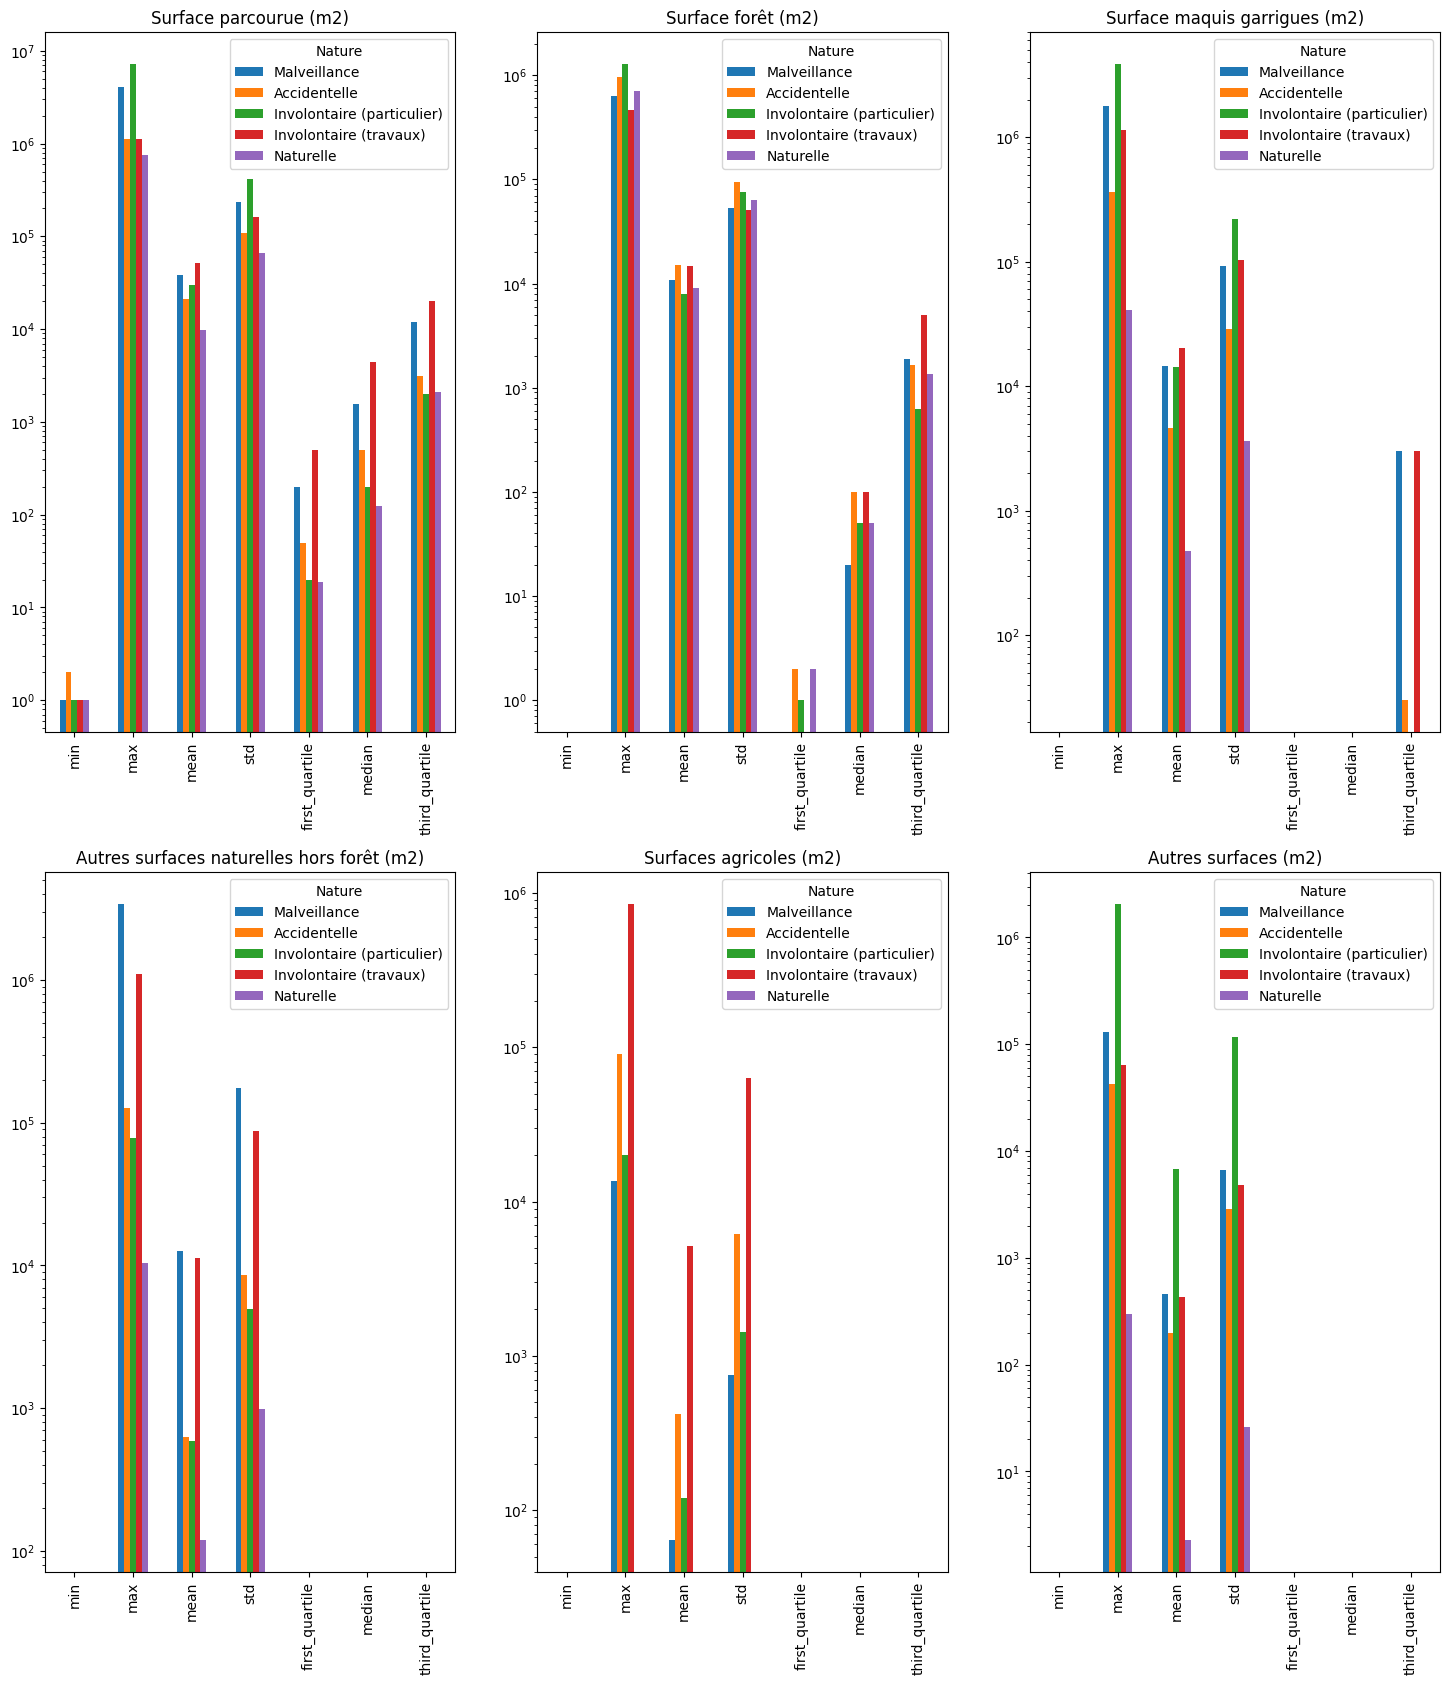

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(18, 20))

surface = "Surface parcourue (m2)"
for index, surface in enumerate(surfaces):
    df_stats_surfaces.loc[surface, :].T.plot(kind="bar", logy=True, title=surface, ax=axes[index // 3][index % 3])

### Conclusion analyses 

Metrics per metrics :
- Classes :
    - the dataset is well balanced, there is just a bit more of "Malveillance" and less "Naturelle"
- Location :
    - southern regions have more fires
    - "hautes-corses" has MANY "Malveillance" fire
    - west-south have a lot of "Naturelle" fire
    - in general, the stats of fire's natures are very different from a departement to another 
- Date :
    - "Naturelle" fire occurs beetween April and October
- Other :
    - buildings are almost never destroyed and poeple are rarely victims of fire so these features might be useless
    - there is more RCCI for "Malveillance" fire and less for "Naturelle" which is expected. In fact, when it's obvious that a fire is "Naturelle", the RCCI team will not be called. In another hand, calling the RCCI team means that we are unsure of the fire nature, this might even mean that potential evidence have been found for "Malveillance" but the team is called for insurance.
    - "Connaissance de la cause" are more often "Probable" when it is "Malveillance" and "Naturelle" but more often "Certaine" when it is "Accidentelle" or "Involontaire*". Evidence and confessions are often more easily discovered when they are accidental or unintentional.
- meteo stats :
    - People that creates "Malveillance" fire are still human so they don't like to go outside when it is too hot (>= 30°C) or too cold (<= 5°C)
    - When there is some precipitation, there is more chances that it is an "Malveillance" fire
    - other metrics seem to influence the number of fires in total but not the number of fires for a specific class
    - "weather_code_category" and "snowfall" does not contain much useful information
    - fire "Naturelle" are more sensitive to meteo, in fact, there is more with when temperature and dew point are around 20 and 10-15 ppmv
    - When relative humidy is high, fire has more chance to be "Naturelle" 
- Surfaces :
    - fire "Naturelle" are less spread in general
    - fire "Involontaire (travaux)" are more spread on "Surface agricoles (m2)"
    - fire "Involontaire (particulier)" are more spread on "Autres surfaces (m2)"
    - fire "Malveillance" are more spread on "Autres surfaces naturelles host forêt (m2)"

## Classification

### Select features

In [27]:
features_one_hot_encoding = [
    "Département",
    "Type de peuplement",
    "month",
    "hour",
]
if ADD_METEO_STATS:
    features_one_hot_encoding.append("weather_code_category")
if KEEP_CHEATING_FEATURES:
    features_one_hot_encoding.extend(["Connaissance de la cause", "Précision des surfaces"])

features_yes_no = [
    "Décès ou bâtiments touchés",
]
if KEEP_CHEATING_FEATURES:
    features_yes_no.append("Intervention de l'équipe RCCI")

features = [
    "Surface parcourue (m2)",
    "Surface forêt (m2)",
    "Surface maquis garrigues (m2)",
    "Autres surfaces naturelles hors forêt (m2)",
    "Surfaces agricoles (m2)",
    "Nombre de décès",
    "Nombre de bâtiments totalement détruits",
]
if ADD_METEO_STATS:
    features.extend(
        [
            "temperature",
            "dew_point",
            "relative_humidity",
            "pressure",
            "precipitation",
            "wind_direction",
            "wind_speed",
            "snowfall",
        ]
    )

# display useful information
pd.DataFrame(
    {c: df[c].unique().shape for c in features_one_hot_encoding},
    index=["Nb features of one hot encodings"],
).T

,Nb features of one hot encodings
Département,53
Type de peuplement,7
month,12
hour,24
weather_code_category,2
Connaissance de la cause,2
Précision des surfaces,2


### Construct input and output

In [28]:
# numeric features
X = df[features].copy()

# one hot encoding features
for column in features_one_hot_encoding:
    for value in np.sort(df[column].unique()):
        X[f"{column}_{value}"] = (df[column] == value).astype(int)

# no, yes features --> 0, 1
for column in features_yes_no:
    X[column] = df[column]
    X.loc[X[column] == "Non", column] = 0
    X.loc[X[column] == "Oui", column] = 1

# classes
label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(df["Nature"].unique())
y = label_encoder.transform(df["Nature"])

print("X.shape :", X.shape)
print("y.shape :", y.shape)
X

X.shape : (1257, 119)
y.shape : (1257,)


,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Nombre de décès,Nombre de bâtiments totalement détruits,temperature,dew_point,relative_humidity,...,hour_22,hour_23,weather_code_category_No significant weather or clear skies,weather_code_category_Precipitation but not reaching the ground,Connaissance de la cause_Certaine,Connaissance de la cause_Probable,Précision des surfaces_Estimées,Précision des surfaces_Mesurées,Décès ou bâtiments touchés,Intervention de l'équipe RCCI
0,100,0.0,100.0,0.0,0.0,0.0,0.0,14.100000,12.300000,89.000000,...,0,0,1,0,0,1,1,0,0,0
2,1000,1000.0,0.0,0.0,0.0,0.0,0.0,21.000000,1.800000,28.000000,...,0,0,1,0,0,1,1,0,0,0
6,200,0.0,200.0,0.0,0.0,0.0,0.0,16.300000,9.200000,63.000000,...,0,0,1,0,1,0,1,0,0,0
7,5000,0.0,5000.0,0.0,0.0,0.0,0.0,18.400000,1.000000,31.000000,...,0,0,1,0,1,0,1,0,0,0
9,1000,1000.0,0.0,0.0,0.0,0.0,0.0,14.600000,9.600000,72.000000,...,0,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,61829,300.0,0.0,61529.0,0.0,0.0,0.0,20.743219,10.030561,53.814647,...,0,0,1,0,0,1,0,1,0,0
2662,97200,200.0,0.0,97000.0,0.0,0.0,0.0,20.743219,10.030561,53.814647,...,0,0,1,0,0,1,0,1,0,0
2663,500,0.0,500.0,0.0,0.0,0.0,0.0,6.900000,3.700000,80.000000,...,0,0,1,0,1,0,1,0,0,0
2668,100,0.0,100.0,0.0,0.0,0.0,0.0,8.300000,7.200000,93.000000,...,0,0,1,0,1,0,1,0,0,0


In [29]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.5, random_state=42
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((628, 119), (629, 119), (628,), (629,))

### Load model

In [30]:
clf = sklearn.linear_model.LogisticRegression(
    penalty="l1",
    solver="liblinear",
    C=10,
    # l1_ratio=l1_ratio,
    class_weight=None,
)
clf = sklearn.ensemble.GradientBoostingClassifier()
clf = sklearn.svm.SVC()
clf = sklearn.linear_model.SGDClassifier()
clf = sklearn.ensemble.RandomForestClassifier(
    **{
        "criterion": "gini",
        "n_estimators": 219,
        "max_depth": 951,
        "min_samples_split": 0.007037553996941826,
    }
)

def build_estimator(clf):
    steps = [clf]
    if NORMALIZE_DATA:
        steps = [sklearn.preprocessing.StandardScaler()] + steps

    return sklearn.pipeline.make_pipeline(*steps)


def init_NN(regu1: float = 0.0000000000001, regu2: float = 0.000000000000):

    # regu1 = keras.regularizers.L2(regu1)
    # regu2 = keras.regularizers.L2(regu2)
    activation = "relu"

    estimator = keras.models.Sequential(
        [
            keras.layers.Input((X_train.shape[1],)),
            # keras.layers.Dense(512, activation=activation),
            # keras.layers.Dense(256, activation=activation),
            # keras.layers.Dense(128, activation=activation),
            # keras.layers.Dense(64, activation=activation),
            keras.layers.Dense(5, activation="softmax"),
        ]
    )
    estimator.compile(
        optimizer=keras.optimizers.SGD(learning_rate=0.0000001),
        loss=keras.losses.CategoricalCrossentropy(),
        # metrics=[keras.metrics.Precision(), keras.metrics.Recall()],
        metrics=["accuracy"]
    )

    estimator.summary()

    return estimator

nn = False
if nn:
    estimator = init_NN()
else:
    estimator = build_estimator(clf)
    print(clf.__class__)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>


### Train

In [31]:
if nn:
    history = estimator.fit(X_train, keras.utils.to_categorical(y_train), epochs=200, batch_size=1000, validation_data=(X_test, keras.utils.to_categorical(y_test)))
else:
    estimator.fit(X_train, y_train)

### Learning curves (for NN)

In [32]:
if nn:
    history.history = {
        key[:-3] if key[-3] == "_" else (key[:-2] if key[-2] == "_" else key): v
        for key, v in history.history.items()
    }
    metrics = ["precision", "recall"]
    metrics = ["accuracy"]

    dic = {
        f"{e1}_{metric}": history.history[f"{e2}{metric}"]
        for metric in (metrics + ["loss"])
        for e1, e2 in [("train", ""), ("test", "val_")]
    }
    l_hist_axes0 = [f"{e}_{metric}" for metric in metrics for e in ["train", "test"]]
    l_hist_axes1 = ["train_loss", "test_loss"]

    df_hist = pd.DataFrame(dic)

    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

    df_hist[l_hist_axes0].plot(kind="line", ax=axes[0])
    df_hist[l_hist_axes1].plot(kind="line", ax=axes[1], logy=True)
else:
    print("Not neural network : no learning curves displayed")

Not neural network : no learning curves displayed


### Cross validation

In [33]:
if True:
    cv = sklearn.model_selection.ShuffleSplit(n_splits=5, test_size=0.3, random_state=1) 
    scores = sklearn.model_selection.cross_val_score(estimator, X, y, cv=cv, scoring="f1_weighted")
    print(scores, scores.mean(), scores.std())

[0.53775464 0.50816962 0.53536058 0.55519896 0.5850213 ] 0.5443010194338396 0.02531865407403599


### Evaluate

In [38]:
print("Classes")
label_encoder.classes_

Classes


array(['Accidentelle', 'Involontaire (particulier)',
       'Involontaire (travaux)', 'Malveillance', 'Naturelle'],
      dtype=object)

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.22      0.28       110
           1       0.58      0.55      0.56       167
           2       0.47      0.28      0.35        92
           3       0.57      0.78      0.66       207
           4       0.41      0.58      0.48        53

    accuracy                           0.53       629
   macro avg       0.49      0.48      0.47       629
weighted avg       0.52      0.53      0.51       629



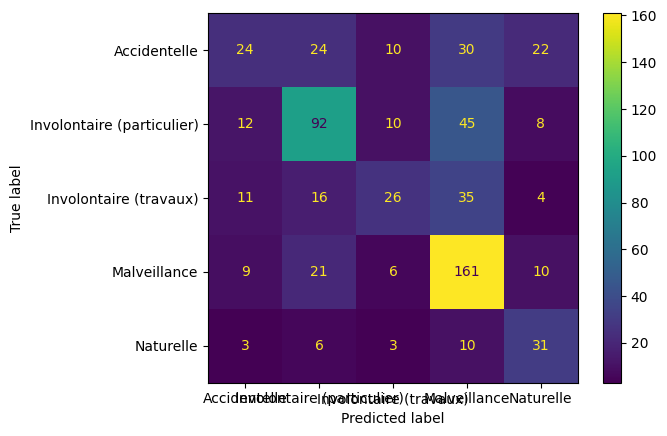

In [35]:
y_pred = estimator.predict(X_test)
if nn:
    y_pred = y_pred.argmax(axis=1)

print("Classification Report:")
print(sklearn.metrics.classification_report(y_true=y_test, y_pred=y_pred))

disp = sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(y_test, y_pred), display_labels=label_encoder.classes_)
disp.plot()

### Optimize parameters

#### Create the objectives function

In [36]:
def objective_base(estimator):

    cv = sklearn.model_selection.ShuffleSplit(n_splits=5, test_size=0.3, random_state=1) 
    scores = sklearn.model_selection.cross_val_score(estimator, X, y, cv=cv, scoring="f1_weighted")
    return scores.mean()

def objective_lr(trial: optuna.trial.Trial): # 48% macro f1 score

    tol = trial.suggest_float("tol", 1e-12, 1e-2)
    c = trial.suggest_float("C", 1e-12, 1e10)
    # solver = trial.suggest_categorical("solver", ["lbfgs", "newton-cg", "newton-cholesky", "sag", "saga"])
    # penalty = trial.suggest_categorical("penalty", [None, "l1", "l2"])
    # l1_ratio = trial.suggest_float("l1_ratio", 0, 1)
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])

    estimator = sklearn.pipeline.make_pipeline(
        sklearn.preprocessing.StandardScaler(),
        sklearn.linear_model.LogisticRegression(
            penalty="l1",
            solver="saga",
            tol=tol,
            C=c,
            # l1_ratio=l1_ratio,
            class_weight=class_weight,
        ),
    )

    return objective_base(estimator)

def objective_sgd(trial: optuna.trial.Trial):

    alpha = trial.suggest_float("alpha", 1e-12, 1e2)
    # l1_ratio = trial.suggest_float("l1_ratio", 0, 1)

    # losses = ["hinge", "log_loss", "modified_huber", "squared_hinge", "perceptron", "squared_error", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"]
    # loss = trial.suggest_categorical("solver", losses)

    estimator = sklearn.pipeline.make_pipeline(
        sklearn.preprocessing.StandardScaler(),
        sklearn.linear_model.SGDClassifier(
            loss="hinge", alpha=alpha, penalty="l2"
        ),
    )

    return objective_base(estimator)

def objective_forest(trial: optuna.trial.Trial):

    criterion = trial.suggest_categorical(
        "criterion", ["gini", "entropy", "log_loss"]
    )
    n_estimators = trial.suggest_int("n_estimators", low=1, high=1000)
    max_depth = trial.suggest_int("max_depth", low=1, high=1000)
    min_samples_split = trial.suggest_float("min_samples_split", low=0, high=1)

    estimator = sklearn.pipeline.make_pipeline(
        sklearn.preprocessing.StandardScaler(),
        sklearn.ensemble.RandomForestClassifier(
            n_estimators=n_estimators,
            criterion=criterion,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
        ),
    )

    return objective_base(estimator)

def objective_SVM(trial: optuna.trial.Trial):
    t_C = trial.suggest_float("C", 0.1, 10, step=0.01)
    t_gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
    t_kernel = trial.suggest_categorical("kernel", [ "poly", "rbf", "sigmoid"])

    estimator = build_estimator(sklearn.svm.SVC(
        C=t_C,
        gamma=t_gamma,
        kernel=t_kernel,
    ))
    
    return objective_base(estimator)

def objective_boost(trial):
    # Define the hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    # Initialize the model with the hyperparameters
    estimator = sklearn.ensemble.GradientBoostingClassifier(**params, random_state=42)

    return objective_base(estimator)

#### Run the expirements

In [37]:
storage_name = "classification.db"
if os.path.exists(storage_name):
    os.remove(storage_name)

optuna.logging.set_verbosity(optuna.logging.INFO)

study = optuna.create_study(
        storage=f"sqlite:///{storage_name}",
        study_name="Classification",
        load_if_exists=False,
        direction="maximize",
    )
study.optimize(func=objective_forest, n_trials=50)

[I 2024-06-30 16:31:46,645] A new study created in RDB with name: Classification
[I 2024-06-30 16:31:48,913] Trial 0 finished with value: 0.1802329064637472 and parameters: {'criterion': 'entropy', 'n_estimators': 555, 'max_depth': 848, 'min_samples_split': 0.9775250506839016}. Best is trial 0 with value: 0.1802329064637472.
[I 2024-06-30 16:31:50,942] Trial 1 finished with value: 0.1802329064637472 and parameters: {'criterion': 'gini', 'n_estimators': 506, 'max_depth': 887, 'min_samples_split': 0.7468042249791933}. Best is trial 0 with value: 0.1802329064637472.
[I 2024-06-30 16:31:52,363] Trial 2 finished with value: 0.2849131684071354 and parameters: {'criterion': 'log_loss', 'n_estimators': 303, 'max_depth': 929, 'min_samples_split': 0.44316895735315487}. Best is trial 2 with value: 0.2849131684071354.
[I 2024-06-30 16:31:55,996] Trial 3 finished with value: 0.1802329064637472 and parameters: {'criterion': 'entropy', 'n_estimators': 947, 'max_depth': 899, 'min_samples_split': 0.825

#### Display the best results and hyperparameters

In [39]:
print(f"Best value: {study.best_value:.4f}")
print("Params :")
for key, value in study.best_trial.params.items():
    if type(value) == float:
        print(f"- {key}: {value:.2f}")
    else:
        print(f"- {key}: {value}")

Best value: 0.5557
Params :
- criterion: log_loss
- n_estimators: 793
- max_depth: 643
- min_samples_split: 0.00


In [41]:
study.best_trial.params

{'criterion': 'log_loss',
 'n_estimators': 793,
 'max_depth': 643,
 'min_samples_split': 0.0038414435560480964}

#### See all expirements results

In [42]:
!optuna-dashboard sqlite:///classification.db

[2024-06-30 16:35:57 +0200] [80805] [INFO] Starting gunicorn 22.0.0
[2024-06-30 16:35:57 +0200] [80805] [INFO] Listening at: http://127.0.0.1:8080 (80805)
[2024-06-30 16:35:57 +0200] [80805] [INFO] Using worker: gthread
[2024-06-30 16:35:57 +0200] [80821] [INFO] Booting worker with pid: 80821
^C
[2024-06-30 16:36:23 +0200] [80805] [INFO] Handling signal: int
[2024-06-30 16:36:24 +0200] [80821] [INFO] Worker exiting (pid: 80821)


### Explainability

#### Train the explainer

In [43]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    mode="classification",
    feature_names=X.columns.to_list(),
    class_names=label_encoder.classes_,
    discretize_continuous=True,
    feature_selection="auto",
)

In [44]:
# predict all proba
y_pred_proba = estimator.predict_proba(X_test)
y_pred = y_pred_proba.argmax(axis=1)

# filter the samples by class (c)
c = 2
proba = 0.5
filt: np.ndarray = (y_test == y_pred) & (y_test == c) & (y_pred_proba[:, c] > proba) # & (X_test["Département_13"] == 0)
y_test_sub = y_test[filt].copy()
X_test_sub = X_test[filt].copy()
y_pred_proba_sub = y_pred_proba[filt].copy()

# display the main information
nature = label_encoder.inverse_transform([c])[0]
print(f"Number of sample that are '{nature}' and predicted '{nature}' with a proba > {proba} : {y_test_sub.shape[0]}")

# select only one sample
i = 0
sample : pd.Series = X_test_sub.iloc[i].copy()
for feature in features_one_hot_encoding:
    value = None
    for index in sample.index:
        assert type(index) == str
        if index.startswith(feature) and sample[index] == 1:
            value = index.split("_")[-1]
    sample.drop([index for index in sample.index if index.startswith(feature)], inplace=True)
    sample[feature] = value

print(sample, end="\n\n")
print("Nature of fire :", nature)

# explain sample
exp = explainer.explain_instance(
    X_test_sub.iloc[i].to_numpy(), estimator.predict_proba, num_features=8, top_labels=1
)
exp.show_in_notebook(show_table=True, show_all=False)

Number of sample that are 'Involontaire (travaux)' and predicted 'Involontaire (travaux)' with a proba > 0.5 : 8
Surface parcourue (m2)                                                        17400
Surface forêt (m2)                                                          12400.0
Surface maquis garrigues (m2)                                                   0.0
Autres surfaces naturelles hors forêt (m2)                                   5000.0
Surfaces agricoles (m2)                                                         0.0
Nombre de décès                                                                 0.0
Nombre de bâtiments totalement détruits                                         0.0
temperature                                                                     3.7
dew_point                                                                      -8.7
relative_humidity                                                              40.0
pressure                                       

### **Conclusion**

##### **Evaluation metric**

We chose the f1-sccore weighted as our main evaluation metrics because :
- accuracy and recall are both important for this study --> f1-score
- the dataset is roughly well-balanced --> weighted

##### **Global performances**

We studied performances of different classifier.
We searched for best hyperparameters for each classifier and we used cross validation for their evaluation. 

In addition, the dataset was normalize by sklearn.preprocessing.StandardScaler.

Here is the results :

|                     |   f1-score-weighted (%) |
|:--------------------|--------------------:|
| xgboost             |              0.5411 |
| SVM                 |              0.5294 |
| random forest       |              0.5454 |
| SGD                 |              0.4968 |
| Logistic Regression |              0.5084 |

We conclude that the type of classifier have not much importance for this study.
Choosing the best one permits to improve at most the performances by 5% which is good but this improvement did not lead us to think that the dataset have some specials characteristics solved by a specific classifier.
Moreover, even if random forest and xgboost are slower compared to the others, the fact that the dataset is not very large makes this differences negligible.

On another hand, the hyperparameters optimization permits to improve the performance but not much either (except for the logistic regression).
That lead us to think that the dataset have some "glass ceiling" may be due to some events that are random and that could not be predicted.

Finally, tests have been made with neural networks but the performances on test dataset was not better.

##### **Pre-process importance**

The data normalization have its importance for the logistic regression, the SGD and the SVM (~+30%).

##### **Features importance**

The meteo stats does seem to improve performances which is a great disappointment because it took us some times to add those information in the original dataset.
Before adding those information, we expected they would at least improved the prediction of "Naturelle" but their importance are negligible.
Our hypotheses are that most of them does not contain much information. That was already obvious for "weather_code", "snowfall" during statistical analyses but it might also be true for "dew_point", "wind_speed", "wind_direction", "pressure" and "temperature".

Analyses with random forest classifier :
- The feature "Intervention de l'équipe RCCI" improves performances from 1 to 2 percent but can be considered as cheating the prediction. In fact, the predictions might help choosing if the RCCI team should or should not step in, it should not be the opposite.
- Same remark for the "Connaissance de la cause" (="Certaine"/"Probable") and "Précision des surfaces" features.
- Adding the data that was not annotated accurate ("Données partielles ou non valides") leads an improve from ~1200 samples to ~1400 samples but drop the performances by 3-4%.  
- Removing departement feature drop the performances by ~10%.

##### **Performances by classes**

- "Involontaire (particulier)", "Malveillance" and "Naturelle" are the categories that are best predicted.
- "Accidentelle" and "Involontaire (travaux)" are not well predicted.

Explanation found with the module 'lime' :
- "Malveillance" :
    - Fires in departement 2b ("Haute-Corse") are always predicted as "Malveillance" : 0.87% of fire in this departement has this nature.
    - It's a bit a default prediction. In fact, when there is no real information that lead to another one, this class is chosen.
    It can be explained by the fact that it's the class the most represented in the dataset.
- "Naturelle" :
    - Fires in departement 40 ("Landes") are often predicted as "Naturelle" : 0.48% of fire in this departement has this nature.
    - Month 1, 2, 3, 11, 12 are never predicited as "Naturelle".
    - Month 1, 2, 3, 11, 12 are never predicited as "Naturelle".
- "Involontaire (particulier)".
    - Fires in departement 13 ("Bouches-du-Rhône") are often predicted as "Involontaire (particulier)" : 0.59% of fire in this departement has this nature.
    - When "Surface maquis garrigues (m2)" and "Surfaces forêt (m2)" are low, this class has higher chances to be predicted.
    - When "Surfaces parcourues (m2)" is high, this class has higher chances to be predicted.
    - When there is "Precipitation but not reaching the ground", this class has higher chances to be predicted.
- "Accidentelle" :
    - When "Surfaces parcourues (m2)" is high, this class has higher chances to be predicted.
    - When "relative_humidity" is low, this class has higher chances to be predicted.
    - The classifier is very unsure each time this class is predicted.
    - The classifier predict more this class by caracteristics of the fire that do not corresponds to the other nature than caracteristics of the fire that do corresponds to this nature. Therefore, this nature may not have specific caracteristics
- "Involontaire (travaux)" :
    - When "Surfaces parcourues (m2)" and "Surface maquis garrigues (m2)" are high, this class has higher chances to be predicted.
    - Fires in departement 48 ("Lozère") are often predicted as "Involontaire (travaux)" : 0.79% of fire in this departement has this nature.
    - When the fire occured in february, this class has higher chances to be predicted : Additional study are needed to determine if repetive fire from worker in february were a succession of unfortunate occurrences or if each year is the same thing. 
    - When "pressure" is high, this class has higher chances to be predicted.
    - When "dew_point" is low, this class has higher chances to be predicted.
    - When there is "Precipitation but not reaching the ground", this class has lower chances to be predicted.

It is sometimes hard to interprete the results given by lime. We can always check the statistics if there is some correlcation but finding an interpretation could still be hard like why the pressure of the meteo improves chances that the fire was "Involontaire (travaux)". Sometimes it is simple like when the "Naturelle" nature is never predicted for fires that occur during winter.
 
When we do not have interpretation, we have two hypothesis :
- There is a reason and maybe a specilist in the question would understand them.
- This is a heuristics found by the classifier that may not be applicable if the dataset were bigger.

##### **Final conclusion**

This study was very interesting but asked a lot of work.
In fact, there is a lot of features so lot of statistical analyses, lot of choice to make on NaN value, to make on feature's format (one hot, yes/no, continuous), a lot of things to interprete from the classifier.

Thus, the study was not much oriented on the classifier but was using the classifier as a tool to understand the dataset.
In fact, many results of the explainer lime lead me to make more stats to understand how the classifier was working. It was truly a ping-pong party beetween stats and classifier results.

Regarding to the results, they are not great but are far from random predictions. Therefore it could discourage or encourage the initiation of "RCCI" investigations as suggested in the indrodution. On another hand, there is so much information/parameters to look at, thus, the classifier sure helps orienting and finding the correlation beetween the parameters and the nature of the fire.  

Thank you for your reading, I hope you enjoyed this study.